In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb

In [2]:
df = pd.read_csv(r'../Final Data/Final_Data.csv')
wheat_price = pd.read_csv(r'../Cleaned Data/Wheat_Price_FRED_clean.csv')
wheat_price = wheat_price.rename(columns={"PWHEAMTUSDM": "Wheat_Price"})
df = pd.merge(df, wheat_price[['observation_date', 'Wheat_Price']], left_on='date', right_on='observation_date', how='left').drop(['observation_date','wheat_price'], axis=1).rename(columns={'Wheat_Price': 'wheat_price'})

In [3]:
df['date'] = pd.to_datetime(df['date'])
exclude_cols = ['date', 'avg_temp', 'drought_idx']
cols_to_logret = [col for col in df.columns if col not in exclude_cols]
logret_df = df[['date']].copy()
for col in cols_to_logret:
    logret_df[col + '_logret'] = (np.log(df[col]) - np.log(df[col].shift(1)))*100

logret_df['avg_temp'] = df['avg_temp']
logret_df['drought_idx'] = df['drought_idx']
logret_df['wheat_price_logret_future'] = logret_df['wheat_price_logret'].shift(-1)
logret_df = logret_df.dropna()

In [4]:
logret_df =  logret_df.set_index("date")   

In [5]:
logret_df_train_data = logret_df.loc[:'2020-01-01']

logret_df_test_data = logret_df.loc['2020-02-01':]

model_wheat = AutoReg(logret_df_train_data["wheat_price_logret_future"], lags=4, exog= logret_df_train_data[['corn_price_logret','drought_idx','fertilizer_idx_logret']]).fit()

# Forecasting
forecast_steps = len(logret_df_test_data)  # Forecast length same as test data

forecast_result = model_wheat.get_prediction(start=len(logret_df_train_data), end=len(logret_df_train_data) + forecast_steps - 1, 
                                              exog_oos = logret_df_test_data[['corn_price_logret','drought_idx','fertilizer_idx_logret']])
forecast_result_mean  = forecast_result.predicted_mean  # Point forecasts
# Confidence intervals (By default, the confidence intervals returned by get_prediction().conf_int() in statsmodels are 95%)
forecast_result_conf_int = forecast_result.conf_int()
print("Predicted values:\n", forecast_result_mean)
print("Confidence intervals:\n", forecast_result_conf_int)

Predicted values:
 2020-02-01   -1.390385
2020-03-01   -0.331662
2020-04-01    0.697047
2020-05-01   -0.083322
2020-06-01   -0.338866
2020-07-01    0.378390
2020-08-01    0.928437
2020-09-01    1.357423
2020-10-01    1.516894
2020-11-01    2.036052
2020-12-01    1.724988
2021-01-01    2.136429
2021-02-01    2.412188
2021-03-01    2.583118
2021-04-01    1.698100
2021-05-01    2.834526
2021-06-01    2.038323
2021-07-01    1.154294
2021-08-01    1.300633
2021-09-01    1.491888
2021-10-01    1.327735
2021-11-01    1.102114
2021-12-01    0.167217
2022-01-01    0.226639
2022-02-01   -0.056649
2022-03-01    1.019255
2022-04-01    0.962596
2022-05-01    0.468703
2022-06-01    0.308379
2022-07-01    0.389753
2022-08-01    0.335413
2022-09-01    0.629945
2022-10-01    0.761285
2022-11-01    0.036988
2022-12-01   -1.108000
2023-01-01   -1.476761
2023-02-01   -1.262229
2023-03-01   -0.961732
2023-04-01   -0.701152
2023-05-01   -1.691799
2023-06-01   -0.173072
2023-07-01    0.417872
2023-08-01   -0

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


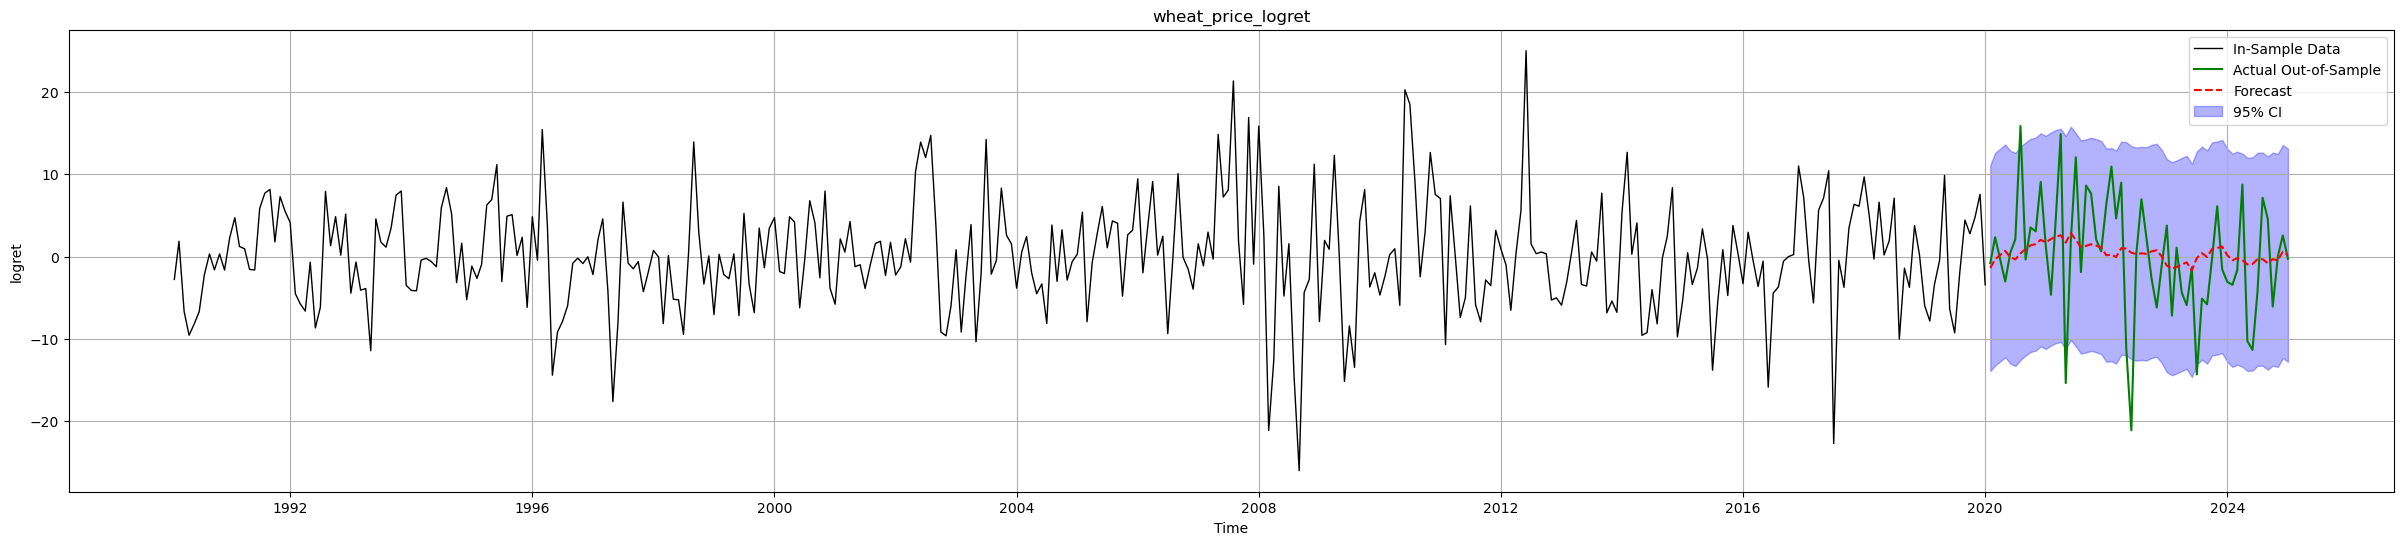

In [6]:
# Plot actual vs forecasted values
plt.figure(figsize=(30, 6))
plt.plot(logret_df_train_data.index, logret_df_train_data["wheat_price_logret_future"], label="In-Sample Data", color="black", linewidth=1)
plt.plot(logret_df_test_data.index, logret_df_test_data["wheat_price_logret_future"], label="Actual Out-of-Sample", color="green", linestyle="solid")
plt.plot(logret_df_test_data.index, forecast_result_mean, label="Forecast", color="red", linestyle="dashed")
# Plot confidence intervals
plt.fill_between(logret_df_test_data.index, forecast_result_conf_int.lower, forecast_result_conf_int.upper, color="blue", alpha=0.3, label="95% CI")

# Formatting
plt.xlabel("Time")
plt.ylabel("logret")
plt.title("wheat_price_logret")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [7]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

best_aic = float('inf')
best_order = None

for p in range(3):
    for d in range(2):
        for q in range(3):
            try:
                arima_model_wheat = ARIMA(logret_df["wheat_price_logret_future"], order=(p,d,q),
                                          exog= logret_df[['corn_price_logret','drought_idx','fertilizer_idx_logret']]).fit()
                if arima_model_wheat.aic < best_aic:
                    best_aic = arima_model_wheat.aic
                    best_order = (p, d, q)
            except:
                continue
                
print(f"Best ARIMA order: {best_order}")
best_arima = ARIMA(logret_df["wheat_price_logret_future"], order = best_order,
                   exog= logret_df[['corn_price_logret','drought_idx','fertilizer_idx_logret']]).fit()
print('\n',best_arima.summary())

Best ARIMA order: (1, 0, 2)

                                    SARIMAX Results                                   
Dep. Variable:     wheat_price_logret_future   No. Observations:                  419
Model:                        ARIMA(1, 0, 2)   Log Likelihood               -1370.793
Date:                       Sat, 10 May 2025   AIC                           2757.587
Time:                               09:35:14   BIC                           2789.890
Sample:                                    0   HQIC                          2770.355
                                       - 419                                         
Covariance Type:                         opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.9641      0.377     -2.560      0.010      -1.702      -0.226
corn_price_l

In [8]:
arima_train=ARIMA(logret_df_train_data["wheat_price_logret_future"], order = best_order,
                   exog= logret_df_train_data[['corn_price_logret','drought_idx','fertilizer_idx_logret']]).fit()
arima_forecast = arima_train.get_prediction(start=len(logret_df_train_data), end=len(logret_df_train_data) + forecast_steps - 1, 
                                              exog = logret_df_test_data[['corn_price_logret','drought_idx','fertilizer_idx_logret']])
arima_forecast_result_mean  = arima_forecast.predicted_mean  # Point forecasts
# Confidence intervals (By default, the confidence intervals returned by get_prediction().conf_int() in statsmodels are 95%)
arima_forecast_result_conf_int = arima_forecast.conf_int()
print("Predicted values:\n", arima_forecast_result_mean)
print("Confidence intervals:\n", arima_forecast_result_conf_int)

Predicted values:
 2020-02-01   -1.135381
2020-03-01    0.159397
2020-04-01    1.105357
2020-05-01   -0.590857
2020-06-01   -0.500615
2020-07-01    0.556661
2020-08-01    0.798852
2020-09-01    1.150135
2020-10-01    1.404276
2020-11-01    2.019707
2020-12-01    1.359534
2021-01-01    2.145733
2021-02-01    2.449330
2021-03-01    2.467350
2021-04-01    1.305262
2021-05-01    3.234189
2021-06-01    1.897647
2021-07-01    1.154810
2021-08-01    1.580236
2021-09-01    1.557236
2021-10-01    1.218919
2021-11-01    0.944622
2021-12-01   -0.088140
2022-01-01    0.243543
2022-02-01   -0.310250
2022-03-01    1.198093
2022-04-01    0.831632
2022-05-01    0.330669
2022-06-01    0.389787
2022-07-01    0.515630
2022-08-01    0.212180
2022-09-01    0.514236
2022-10-01    0.820708
2022-11-01   -0.090469
2022-12-01   -1.332309
2023-01-01   -1.425530
2023-02-01   -1.096337
2023-03-01   -0.986852
2023-04-01   -0.646324
2023-05-01   -2.029031
2023-06-01    0.329750
2023-07-01    0.539391
2023-08-01   -0

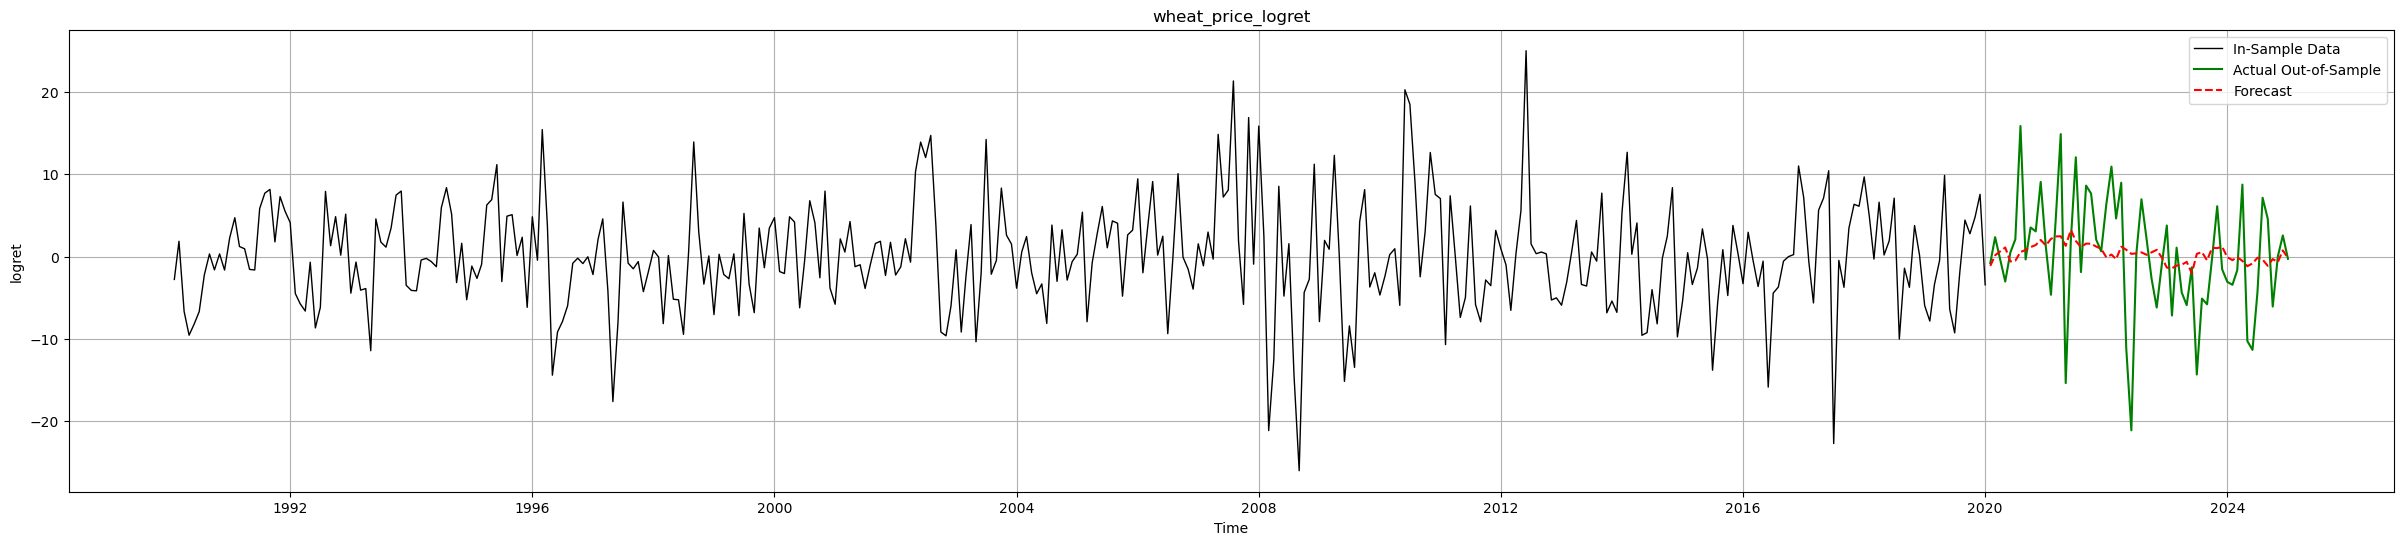

In [9]:
plt.figure(figsize=(30, 6))
plt.plot(logret_df_train_data.index, logret_df_train_data["wheat_price_logret_future"], label="In-Sample Data", color="black", linewidth=1)
plt.plot(logret_df_test_data.index, logret_df_test_data["wheat_price_logret_future"], label="Actual Out-of-Sample", color="green", linestyle="solid")
plt.plot(logret_df_test_data.index, arima_forecast_result_mean, label="Forecast", color="red", linestyle="dashed")

# Formatting
plt.xlabel("Time")
plt.ylabel("logret")
plt.title("wheat_price_logret")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

best_aic = float('inf')
best_order = None
best_seasonal = None

for P in range(2):
    for D in range(2):
        for Q in range(2):
            for p in range(3):
                for d in range(2):
                    for q in range(3):
                        try:
                            sarimax_model_wheat = SARIMAX(logret_df["wheat_price_logret_future"], order=(p,d,q),seasonal_order=(P, D, Q, 12),
                                          exog= logret_df[['corn_price_logret','drought_idx','fertilizer_idx_logret']]).fit(disp=False)
                            if sarimax_model_wheat.aic < best_aic:
                                best_aic = sarimax_model_wheat.aic
                                best_order = (p, d, q)
                                best_seasonal = (P,D,Q,12)
                        except:
                            continue

print(f"Best SARIMAX order: {best_order}x{best_seasonal}")
best_sarimax = SARIMAX(logret_df["wheat_price_logret"], order = best_order,seasonal_order = best_seasonal,
                   exog= logret_df[['corn_price_logret','drought_idx','fertilizer_idx_logret']]).fit(disp=False)
print('\n',best_sarimax.summary())

Best SARIMAX order: (1, 0, 2)x(1, 1, 1, 12)

                                       SARIMAX Results                                       
Dep. Variable:                   wheat_price_logret   No. Observations:                  419
Model:             SARIMAX(1, 0, 2)x(1, 1, [1], 12)   Log Likelihood               -1292.022
Date:                              Sat, 10 May 2025   AIC                           2602.045
Time:                                      09:38:16   BIC                           2638.124
Sample:                                           0   HQIC                          2616.323
                                              - 419                                         
Covariance Type:                                opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
corn_price_logret         0.63

In [11]:
sarimax_train=SARIMAX(logret_df_train_data["wheat_price_logret_future"], order = best_order,seasonal_order = best_seasonal,
                   exog= logret_df_train_data[['corn_price_logret','drought_idx','fertilizer_idx_logret']]).fit(disp=False)
sarimax_forecast = sarimax_train.get_prediction(start=len(logret_df_train_data), end=len(logret_df_train_data) + forecast_steps - 1, 
                                              exog = logret_df_test_data[['corn_price_logret','drought_idx','fertilizer_idx_logret']])
sarimax_forecast_result_mean  = sarimax_forecast.predicted_mean
# Confidence intervals (By default, the confidence intervals returned by get_prediction().conf_int() in statsmodels are 95%)
sarimax_forecast_result_conf_int = sarimax_forecast.conf_int()
print("Predicted values:\n", sarimax_forecast_result_mean)
print("Confidence intervals:\n", sarimax_forecast_result_conf_int)

Predicted values:
 2020-02-01   -1.698180
2020-03-01   -0.917333
2020-04-01    1.374461
2020-05-01   -3.061359
2020-06-01   -0.584195
2020-07-01    0.830708
2020-08-01    2.096565
2020-09-01    2.132020
2020-10-01    1.220143
2020-11-01    3.488445
2020-12-01    1.753295
2021-01-01    3.319054
2021-02-01    2.229138
2021-03-01    2.220922
2021-04-01    2.695053
2021-05-01    3.061352
2021-06-01    1.521147
2021-07-01    0.327248
2021-08-01    2.044668
2021-09-01    3.122544
2021-10-01    1.924264
2021-11-01    3.246346
2021-12-01    0.710839
2022-01-01    0.754549
2022-02-01   -0.369204
2022-03-01    0.624402
2022-04-01    1.412526
2022-05-01   -0.951109
2022-06-01   -0.742793
2022-07-01   -0.216252
2022-08-01    0.997962
2022-09-01    1.909966
2022-10-01    0.690909
2022-11-01    0.903593
2022-12-01   -1.437100
2023-01-01   -1.986350
2023-02-01   -2.573016
2023-03-01   -2.464760
2023-04-01   -0.820198
2023-05-01   -3.834259
2023-06-01   -0.704064
2023-07-01   -0.456416
2023-08-01    0

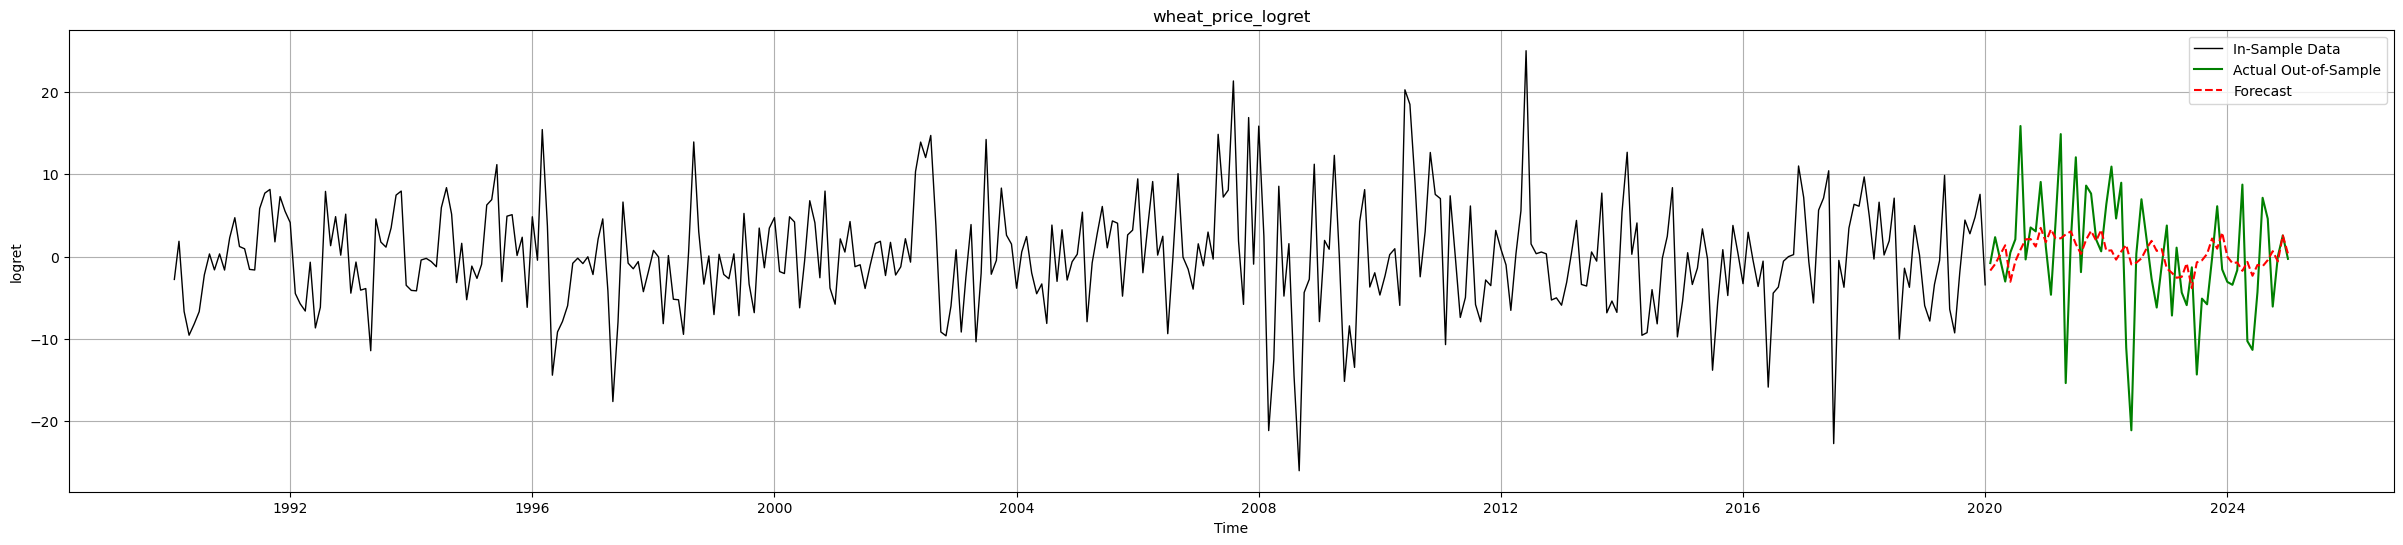

In [12]:
plt.figure(figsize=(30, 6))
plt.plot(logret_df_train_data.index, logret_df_train_data["wheat_price_logret_future"], label="In-Sample Data", color="black", linewidth=1)
plt.plot(logret_df_test_data.index, logret_df_test_data["wheat_price_logret_future"], label="Actual Out-of-Sample", color="green", linestyle="solid")
plt.plot(logret_df_test_data.index, sarimax_forecast_result_mean, label="Forecast", color="red", linestyle="dashed")

# Formatting
plt.xlabel("Time")
plt.ylabel("logret")
plt.title("wheat_price_logret")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [13]:
# Primary variables with multiple lags
primary_vars = ['wheat_price_logret', 'corn_price_logret', 'drought_idx']
primary_lags = [1, 2, 3, 6, 12]  # More comprehensive lag structure

# Secondary variables with fewer lags
secondary_vars = ['fertilizer_idx_logret', 'crude_oil_price_logret', 'flour_price_logret']
secondary_lags = [1, 3, 6]

df_lagged = logret_df.copy()

# Create lags for primary variables
for var in primary_vars:
    for lag in primary_lags:
        df_lagged[f'{var}_lag_{lag}'] = df_lagged[var].shift(lag)

# Create lags for secondary variables
for var in secondary_vars:
    for lag in secondary_lags:
        df_lagged[f'{var}_lag_{lag}'] = df_lagged[var].shift(lag)

# Drop rows with NaN values (due to lagging)
df_lagged = df_lagged.dropna()

In [14]:
lagged_df_train = logret_df.loc[:'2020-01-01']

lagged_df_test = logret_df.loc['2020-02-01':]

X_train = lagged_df_train.drop(columns='wheat_price_logret_future')
X_test = lagged_df_test.drop(columns='wheat_price_logret_future')
y_train = lagged_df_train['wheat_price_logret_future']
y_test = lagged_df_test['wheat_price_logret_future']

In [15]:
from sklearn.tree import DecisionTreeRegressor
dt_model = DecisionTreeRegressor(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

In [16]:
dt_forecast = dt_model.predict(X_test)
dt_forecast_series = pd.Series(dt_forecast, index=X_test.index, name='forecast')

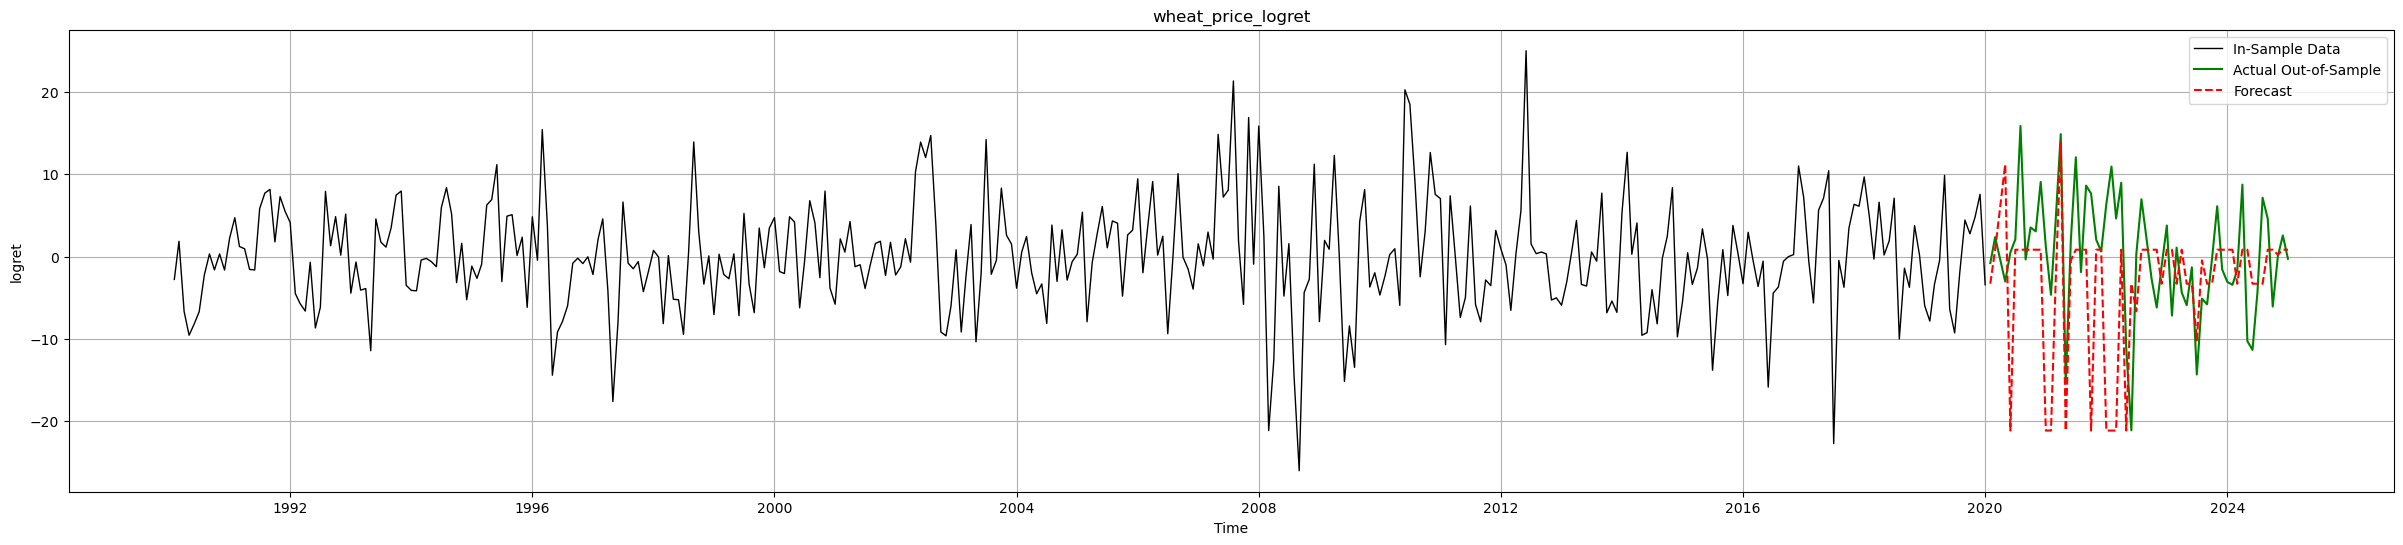

In [17]:
plt.figure(figsize=(30, 6))
plt.plot(logret_df_train_data.index, logret_df_train_data["wheat_price_logret_future"], label="In-Sample Data", color="black", linewidth=1)
plt.plot(logret_df_test_data.index, logret_df_test_data["wheat_price_logret_future"], label="Actual Out-of-Sample", color="green", linestyle="solid")
plt.plot(logret_df_test_data.index, dt_forecast_series, label="Forecast", color="red", linestyle="dashed")

# Formatting
plt.xlabel("Time")
plt.ylabel("logret")
plt.title("wheat_price_logret")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [18]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from xgboost import XGBRegressor
tscv = TimeSeriesSplit(n_splits=5)

# Define parameter grid to search
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)


grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Use negative MSE as the scoring metric
    cv=tscv,                           # Time series cross-validation
    verbose=1,
    n_jobs=-1                          # Use all available cores
).fit(X_train,y_train)

# Perform grid search
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters found: {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.9}


In [19]:
best_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    **best_params
)
best_xgb.fit(X_train, y_train)

# Make predictions
xgb_forecast = best_xgb.predict(X_test)

# Create a Series with the forecast results and the same index as test_data
xgb_forecast_series = pd.Series(xgb_forecast, index=X_test.index, name='forecast')

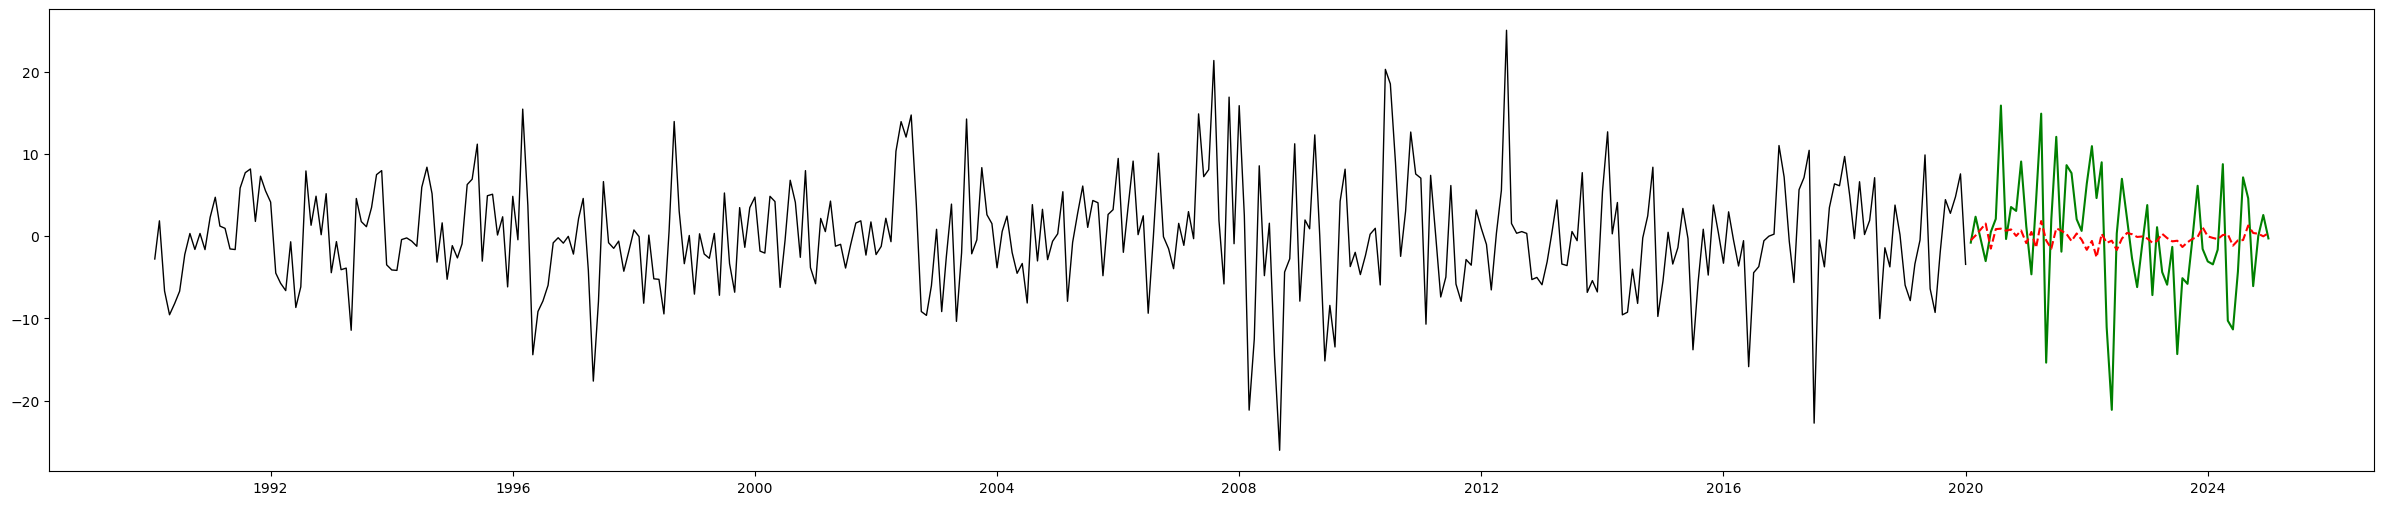

In [20]:
plt.figure(figsize=(30, 6))
plt.plot(logret_df_train_data.index, logret_df_train_data["wheat_price_logret_future"], label="In-Sample Data", color="black", linewidth=1)
plt.plot(logret_df_test_data.index, logret_df_test_data["wheat_price_logret_future"], label="Actual Out-of-Sample", color="green", linestyle="solid")
plt.plot(logret_df_test_data.index, xgb_forecast_series, label="Forecast", color="red", linestyle="dashed")

In [21]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_xgb.feature_importances_
}).sort_values('Importance', ascending=False).head(10)

print("\nTop 10 Most Important Features:")
print(feature_importance)


Top 10 Most Important Features:
                    Feature  Importance
7        wheat_price_logret    0.189341
8                  avg_temp    0.118884
3  commodity_exp_idx_logret    0.115727
9               drought_idx    0.107770
2  commodity_imp_idx_logret    0.101807
4        flour_price_logret    0.096782
6    crude_oil_price_logret    0.089749
5         corn_price_logret    0.075413
1                cpi_logret    0.060653
0     fertilizer_idx_logret    0.043874


In [22]:
actual_values = logret_df_test_data["wheat_price_logret_future"]
forecasts = {
    'AutoReg': forecast_result_mean,
    'ARIMA': arima_forecast_result_mean,
    'SARIMAX': sarimax_forecast_result_mean,
    'Decision Tree': dt_forecast_series,
    'XGBoost': xgb_forecast_series
}

# Calculate metrics
results = []
for model_name, predicted_values in forecasts.items():
    mse = mean_squared_error(actual_values, predicted_values)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_values, predicted_values)
    
    results.append({
        'Model': model_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    })
results_df = pd.DataFrame(results).sort_values('RMSE')
results_df

,Model,MSE,RMSE,MAE
1,ARIMA,47.669336,6.904298,5.199323
0,AutoReg,47.732274,6.908855,5.187582
2,SARIMAX,48.030237,6.930385,5.341519
4,XGBoost,48.681428,6.977208,5.447698
3,Decision Tree,112.797667,10.620625,7.388946
